In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
messi = plt.imread("messi.jpeg")

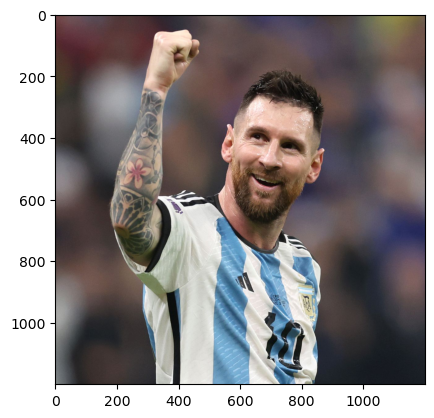

In [3]:
messiplt = plt.imshow(messi)

In [4]:
def togrey(img):
    grey_img = np.dot(img[...,:3], [0.299, 0.587, 0.114])
    return grey_img

In [5]:
messi_grey = togrey(messi)

In [8]:
# WRONG
def gaussiankernel(size, sigma):
    # size is (2k+1)x(2k+1)
    # 1 ≤ i
    # j ≤ 2k+1
    k = (size-1)/2
    kernel = np.fromfunction(lambda i, j: 1/(2*np.pi*sigma**2)*np.exp(((i-(k+1))**2 + (j-(k+1))**2))/2*sigma**2, (size,size))
    norm_factor = np.sum(kernel)
    kernel /= norm_factor # sum of all elements remains 1
    return kernel

In [11]:
# FIGURE OUT WHAT THIS MEANS
def gaussian_kernel(size, sigma):
    # size is (2k+1)x(2k+1)
    # 1 ≤ i
    # j ≤ 2k+1
    kernel = np.zeros((size, size))
    center = size // 2

    for i in range(size):
        for j in range(size):
            x, y = i - center, j - center
            kernel[i, j] = np.exp(-(x**2 + y**2) / (2 * sigma**2))

    kernel /= np.sum(kernel)  # Normalize the kernel

    return kernel

In [15]:
def conv_2d(image, kernel):
    kernel_height, kernel_width = kernel.shape
    image_height, image_width = image.shape
    output = np.zeros_like(image)
    
    # pads image
    padded_image = np.pad(image, ((kernel_height//2, kernel_height//2), (kernel_width//2, kernel_width//2)), mode='constant')

    for y in range(kernel_height//2,image_height):
        for x in range(kernel_width//2,image_width):
            
            region = padded_image[(y-kernel_height//2):y+kernel_height//2 + 1, x-kernel_width//2:x+kernel_width//2 + 1]
            output[y, x] = sum(region.flatten() * kernel.flatten())
    
    return output

In [18]:
def gaussianblur(image, size, sigma):
    kernel = gaussian_kernel(size,sigma)
    blurred_image = conv_2d(image,kernel)
    return blurred_image

In [21]:
blurred_messi = gaussianblur(messi_grey, size = 11, sigma = 5)

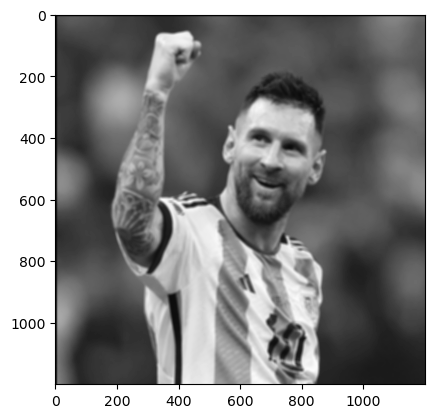

In [108]:
plt.imshow(blurred_messi,cmap = "gray")

In [35]:
def sobel_gradient(image):
    gx = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
    gy = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
    image_height, image_width = image.shape
    new_image = np.zeros_like(image)
    edge_orientation = np.zeros_like(image)
    
    # pads image
    padded_image = np.pad(image, ((1, 1), (1, 1)), mode='constant')

    for y in range(1,image_height):
        for x in range(1,image_width):
            region = padded_image[(y-1):(y+2), (x-1):(x+2)]
            new_image[y,x] = np.sqrt(sum(region.flatten() * gx.flatten())**2 + sum(region.flatten() * gy.flatten())**2)
            edge_orientation[y,x] = np.arctan2(sum(region.flatten() * gy.flatten()),sum(region.flatten() * gx.flatten()))
    
    return [new_image, edge_orientation]

In [36]:
messi_sobel = sobel_gradient(blurred_messi)

In [109]:
dog_sobel = sobel_gradient(blurred_dog)

In [39]:
messi_edged = messi_sobel[0]

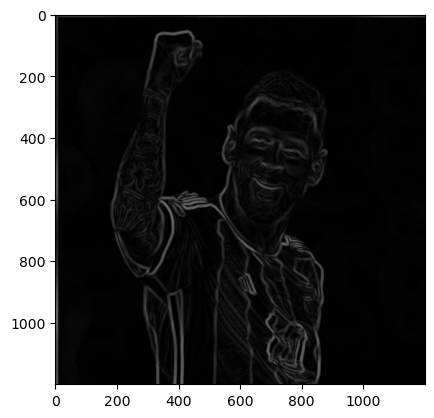

In [98]:
plt.imshow(messi_edged,cmap = "gray")

In [42]:
messi_edge_or = messi_sobel[1]

In [146]:
def non_max_suppression(edge_mags, edge_ors):

    image_height, image_width = edge_mags.shape
    result = np.zeros_like(edge_mags, dtype=np.uint8)

    edge_ors_quantized = (np.round(edge_ors / (np.pi/4)) % 4).astype(int)

    for y in range(1, image_height - 1):
        for x in range(1, image_width - 1):
            current_pixel = edge_mags[y, x]

            if edge_ors_quantized[y, x] == 0:  # 0 degrees
                neighbors = (edge_mags[y, x - 1], edge_mags[y, x + 1])
            elif edge_ors_quantized[y, x] == 1:  # 45 degrees
                neighbors = (edge_mags[y - 1, x - 1], edge_mags[y + 1, x + 1])
            elif edge_ors_quantized[y, x] == 2:  # 90 degrees
                neighbors = (edge_mags[y - 1, x], edge_mags[y + 1, x])
            elif edge_ors_quantized[y, x] == 3:  # 135 degrees
                neighbors = (edge_mags[y - 1, x + 1], edge_mags[y + 1, x - 1])
            
            if current_pixel >= max(neighbors):
                result[y, x] = current_pixel

    return result

In [149]:
messi_non_max_sup = non_max_suppression(messi_edged, messi_edge_or)

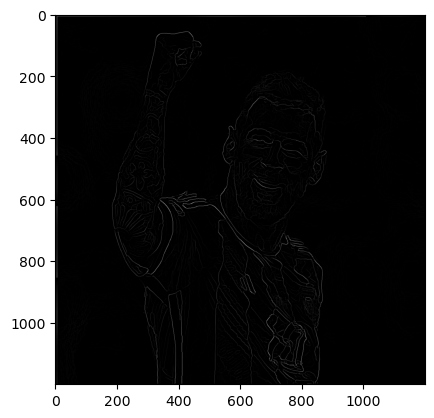

In [151]:
plt.imshow(messi_non_max_sup,cmap = "gray")

In [161]:
def double_threshold(image,higher,lower):
    edge_strength = np.zeros_like(image)
    image_height, image_width = image.shape
    
    for y in range(image_height):
        for x in range(image_width):
            if image[y,x] > higher:
                edge_strength[y,x] = 2
            elif image[y,x] < lower:
                pass
            else:
                edge_strength[y,x] = 2
                
    return edge_strength

In [162]:
messi_edge_strength = double_threshold(messi_non_max_sup,150,50)

In [172]:
def hysteresis(image,edge_strengths):
    image_height, image_width = image.shape
    result = np.zeros_like(image, dtype=np.uint8)

    for y in range(1, image_height - 1):
        for x in range(1, image_width - 1):
            if edge_strengths[y,x] == 1:
                neighbor_strengths = np.concatenate((edge_strengths[y+1,x-1:x+2],edge_strengths[y,x-1],edge_strengths[y,x+1],edge_strengths[y-1,x-1:x+2]),axis = 0).flatten()   
                if 2 in neighbor_strengths:
                    result[y,x] = image[y,x]
            elif edge_strengths[y,x] == 2:
                result[y,x] = image[y,x]

    return result

In [173]:
messi_hysteresized = hysteresis(messi_non_max_sup, messi_edge_strength)

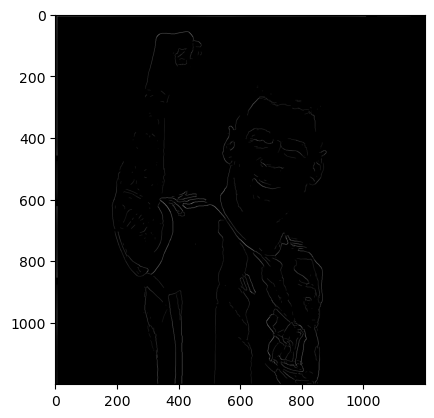

In [174]:
plt.imshow(messi_hysteresized,cmap = "gray")

In [176]:
def edge_detect_pipeline(image,gblur_size,gblur_sigma,t_high,t_low):
    grey_img = togrey(image)
    blurred_img = gaussianblur(grey_img,gblur_size,gblur_sigma)
    sobel_img = sobel_gradient(blurred_img)
    nmax_sup_img = non_max_suppression(sobel_img[0],sobel_img[1])
    edge_strengths = double_threshold(nmax_sup_img,t_high,t_low)
    return hysteresis(nmax_sup_img,edge_strengths)

In [188]:
messi_edge = edge_detect_pipeline(messi,5,2,150,50)

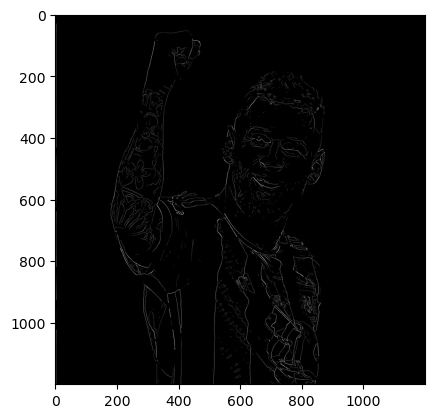

In [189]:
plt.imshow(messi_edge,cmap = "gray")

In [179]:
dog = plt.imread("dog.jpeg")

In [184]:
dog_edge = edge_detect_pipeline(dog,7,3,200,100)

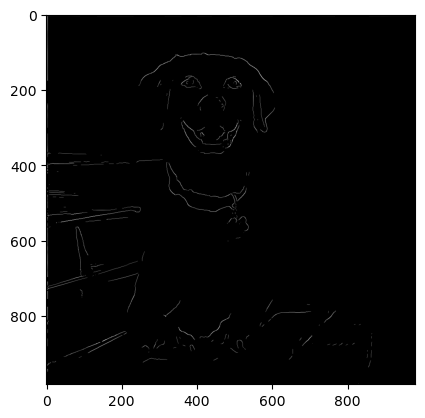

In [185]:
plt.imshow(dog_edge,cmap = "gray")